### Imports

In [1]:
from api import *
from collections import defaultdict
import os

### Import data

In [2]:
# Import these reports
clean_birmingham_report_df = pd.read_feather('image_time_traffic_reports/clean_birmingham_report_df')
clean_manc_report_df = pd.read_feather('image_time_traffic_reports/clean_manc_report_df')
clean_cam_report_df = pd.read_feather('image_time_traffic_reports/clean_cam_report_df')
clean_thorpe_report_df = pd.read_feather('image_time_traffic_reports/clean_thorpe_report_df')
clean_epping_report_df = pd.read_feather('image_time_traffic_reports/clean_epping_report_df')
clean_bristol_df = pd.read_feather('image_time_traffic_reports/clean_bristol_df')

In [3]:
import copy
road_lengths = pd.read_csv('road_lengths.csv') 
traffc_data_england = copy.copy(road_lengths)

In [4]:
clean_train_report_df = pd.concat([clean_birmingham_report_df, clean_manc_report_df, clean_cam_report_df, clean_thorpe_report_df, clean_epping_report_df, clean_bristol_df])


sites = []
for x in list(traffc_data_england.sites):
    sites = sites + x.split(', ')
    
filtered_train_report = clean_train_report_df[['site_name','site_id','report_date','time_period_ending','time_interval','0-520cm','521-660cm','661-1160cm','1160+cm','avg_mph','total_volume','timestamp']][clean_train_report_df.site_id.isin(sites)]

In [5]:
# For a particular row x in road_lengths get the correspoiding traffic data
def area_report(x):
    sites = x.sites.split(', ')
    day, month, year = x.ddmmyy.split('/')
    hour, minute  = x.time.split(':')
    
    # Get the nearest of the 15 minute intervals to compare to
    min_mod_15 = round((int(minute)+1)/15)
    nearest_minute_interval = 15*min_mod_15 - 1
    time = datetime.datetime(int(year),int(month),int(day), int(hour), int(nearest_minute_interval))
    x_report = filtered_train_report[(filtered_train_report.site_id.isin(sites)) & (filtered_train_report.timestamp == time)]
    return x_report

# Add the reports to the dataframe
traffc_data_england['report'] = traffc_data_england.apply(area_report, axis=1)
# Extract values from the report
traffc_data_england['0-520cm'] = traffc_data_england.apply(lambda x: x.report['0-520cm'].sum(), axis=1)
traffc_data_england['521-660cm'] = traffc_data_england.apply(lambda x: x.report['521-660cm'].sum(), axis=1)
traffc_data_england['661-1160cm'] = traffc_data_england.apply(lambda x: x.report['661-1160cm'].sum(), axis=1)
traffc_data_england['1160+cm'] = traffc_data_england.apply(lambda x: x.report['1160+cm'].sum(), axis=1)
traffc_data_england['total_volume'] = traffc_data_england.apply(lambda x: x.report['total_volume'].sum(), axis=1)
traffc_data_england['avg_mph'] = traffc_data_england.apply(lambda x: x.report.avg_mph.astype(int).mean(), axis=1)

In [6]:
def predict_traffic_from_detector(data, threshold, pickle_folder):
    
    traffic_data = copy.copy(data)
    # Initially set the column names so they agree with the names in the pickle files
    detections = pd.DataFrame(
       {
           "filename": [],
           "small_car_detections": [],
           "bus_detections": [],
           "pickup_truck_detections": [],
           "utility_truck_detections": [],
           "truck_detections": [],
           "cargo_truck_detections": [],
           "truck_w_box_detections": [],
           "truck_tractor_detections": [],
           "trailer_detections": [],
           "truck_w_flatbed_detections": [],
           "truck_w_liquid_detections": [],
           "all_vehicle_detections": [],

       }
    )

    # Import the predictions the pickle files
    prediction_lists = defaultdict()

    for i, file in enumerate(os.listdir(pickle_folder)):
        with (open(os.path.join(pickle_folder, file), "rb")) as f:
            prediction_list = pickle.load(f)
        filename = file.split('.')[0]
        prediction_lists[filename] = prediction_list
        counts = defaultdict(int)
        for pred in prediction_list:
            if pred.score.value > threshold:
                counts[pred.category.name] +=1

        detections.loc[i] = [filename, 
                     counts["Small Car"],
                     counts["Bus"],
                     counts["Pickup Truck"],
                     counts["Utility Truck"],
                     counts["Truck"],
                     counts["Cargo Truck"],
                     counts["Truck w/Box"],
                     counts["Truck Tractor"],
                     counts["Trailer"],
                     counts["Truck w/Flatbed"],
                     counts["Truck w/Liquid"],
                     sum([x for x in counts.values()])]
        
    # combine the reports    
    def detection_report(x):
        detections_report = detections[detections.filename == x.filename]
        return detections_report
    
    traffic_data['det_report'] = traffic_data.apply(detection_report, axis=1)
    
    # get the detection numbers
    traffic_data['small_car_detections'] = traffic_data.apply(lambda x: x.det_report.small_car_detections.sum(), axis=1)
    traffic_data['bus_detections'] = traffic_data.apply(lambda x: x.det_report.bus_detections.sum(), axis=1)
    traffic_data['pickup_truck_detections'] = traffic_data.apply(lambda x: x.det_report.pickup_truck_detections.sum(), axis=1)
    traffic_data['utility_truck_detections'] = traffic_data.apply(lambda x: x.det_report.utility_truck_detections.sum(), axis=1)
    traffic_data['truck_detections'] = traffic_data.apply(lambda x: x.det_report.truck_detections.sum(), axis=1)
    traffic_data['cargo_truck_detections'] = traffic_data.apply(lambda x: x.det_report.cargo_truck_detections.sum(), axis=1)
    traffic_data['truck_w_box_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_box_detections.sum(), axis=1)
    traffic_data['truck_tractor_detections'] = traffic_data.apply(lambda x: x.det_report.truck_tractor_detections.sum(), axis=1)
    traffic_data['trailer_detections'] = traffic_data.apply(lambda x: x.det_report.trailer_detections.sum(), axis=1)
    traffic_data['truck_w_flatbed_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_flatbed_detections.sum(), axis=1)
    traffic_data['truck_w_liquid_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_liquid_detections.sum(), axis=1)
    traffic_data['all_vehicle_detections'] = traffic_data.apply(lambda x: x.det_report.all_vehicle_detections.sum(), axis=1)

    # Predict the traffic count from these detections via raodlength and avg speed
    traffic_data['length_milles'] = traffic_data.length.apply(lambda x: x/1000 *5/8)
    traffic_data['time_to_cross_hour'] = traffic_data.apply(lambda x : x.length_milles/x.avg_mph * 1/2 , axis=1)
    traffic_data['time_to_cross_min'] = traffic_data.apply(lambda x : x.time_to_cross_hour * 60 , axis=1)

    detection_cols = ['small_car_detections',
     'bus_detections',
     'pickup_truck_detections',
     'utility_truck_detections',
     'truck_detections',
     'cargo_truck_detections',
     'truck_w_box_detections',
     'truck_tractor_detections',
     'trailer_detections',
     'truck_w_flatbed_detections',
     'truck_w_liquid_detections',
     'all_vehicle_detections']

    for col in detection_cols:
        pred_col = col.replace('detections', 'pred')
        traffic_data[pred_col] = traffic_data[col] * 15 / traffic_data['time_to_cross_min']
        
    return traffic_data

In [7]:
pickle_folder = '../inference/inference-WV3/tood-low-threshold/pickles'
traffic_data_tood = predict_traffic_from_detector(traffc_data_england, 0.2, pickle_folder)

In [8]:
pickle_folder = '../inference/inference-WV3/yolov5-low-threshold/pickles'
traffic_data_yolov5 = predict_traffic_from_detector(traffc_data_england, 0.3, pickle_folder)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import numpy as np

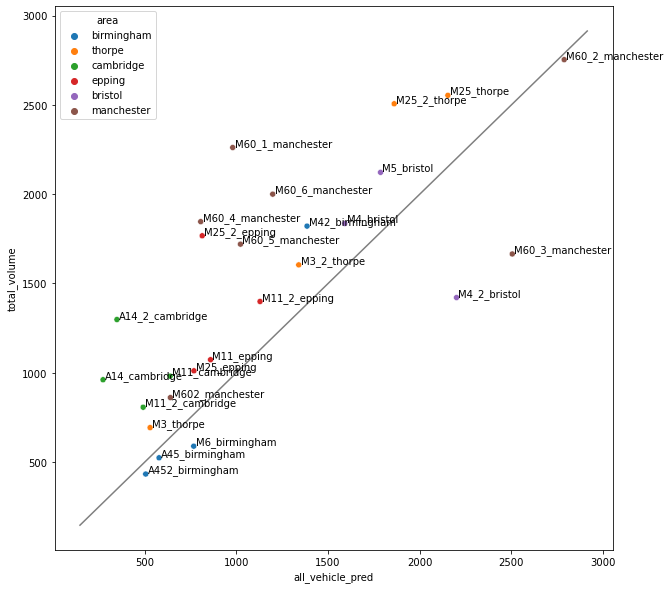

In [11]:
plot_data = traffic_data_tood

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='all_vehicle_pred', y='total_volume', hue='area', data=plot_data, ax=ax)
for i in range(plot_data.shape[0]):
     plt.text(plot_data.all_vehicle_pred[i]+10, plot_data.total_volume[i]+10, plot_data.filename[i])
        
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.5)
        
plt.show()

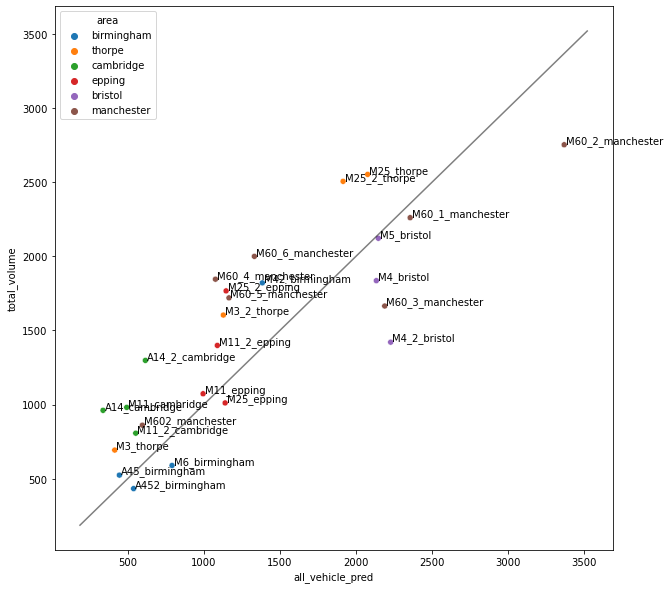

In [12]:
plot_data = traffic_data_yolov5

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='all_vehicle_pred', y='total_volume', hue='area', data=plot_data, ax=ax)
for i in range(plot_data.shape[0]):
     plt.text(plot_data.all_vehicle_pred[i]+10, plot_data.total_volume[i]+10, plot_data.filename[i])
        
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.5)
        
plt.show()

In [13]:
pickle_folder = '../inference/inference-WV3/yolov5-low-threshold/pickles'
predictions = {}
mse_dict = {}
for x in range(5,100,5):
    threshold = x/100
    predictions[threshold] = predict_traffic_from_detector(traffc_data_england, threshold, pickle_folder)
    mse = ((predictions[threshold].total_volume.values - predictions[threshold].all_vehicle_pred.values)**2).sum()/len(predictions[threshold])
    mse_dict[threshold] = mse
    
    

best_threshold = min(mse_dict, key=mse_dict.get)
print(f"the best threshold {best_threshold} gives rmse {mse_dict[best_threshold]**0.5}")    

the best threshold 0.25 gives rmse 439.6783804584062


In [14]:
pickle_folder = '../inference/inference-WV3/tood-low-threshold/pickles'
predictions = {}
mse_dict = {}
for x in range(5,100,5):
    threshold = x/100
    predictions[threshold] = predict_traffic_from_detector(traffc_data_england, threshold, pickle_folder)
    mse = ((predictions[threshold].total_volume.values - predictions[threshold].all_vehicle_pred.values)**2).sum()/len(predictions[threshold])
    mse_dict[threshold] = mse
    
    

best_threshold = min(mse_dict, key=mse_dict.get)
print(f"the best threshold {best_threshold} gives rmse {mse_dict[best_threshold]**0.5}")    

the best threshold 0.15 gives rmse 518.220374967747


In [15]:
np.absolute(((traffic_data_yolov5.total_volume.values - traffic_data_yolov5.all_vehicle_pred.values) / traffic_data_yolov5.all_vehicle_pred.values)).mean()

0.4269617263012816

In [34]:
time = datetime.datetime(2019,4,19,12,44)

In [65]:
clean_train_report_df[(clean_train_report_df.timestamp==time) & (clean_train_report_df.site_id == '1993')]

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
338,M602/6013B,1993,2019-04-19T00:00:00,12:44:00,50,381,55,16,11,59,463,2019-04-19 12:44:00,1.770121,1.559823,1.596674,1.504274,1.728687


In [66]:
clean_train_report_df[(clean_train_report_df.timestamp==time) & (clean_train_report_df.site_id == '1563')]

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
146,M602/6029B,1563,2019-04-19T00:00:00,12:44:00,50,287,160,17,16,67,480,2019-04-19 12:44:00,1.63397,2.012842,1.51814,1.922403,1.747639
